# 2D Soccer Simulation League Expected Goals Model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

## Loading database
In this section, we load the database generated files to use in the model

In [ ]:
dir = os.getcwd()
with open(os.path.join(dir, 'database/data/database_2019+2021.csv')) as f:
    data = pd.read_csv(f)

In [4]:
data.tail()

,x,y,distance,angle,players_in_between,goal
5984,17.1540,-22.4286,41.861460,0.283130,2,0
5985,33.8547,-9.0582,20.729163,0.601883,9,0
5986,6.8481,-30.9291,55.142590,0.210771,2,0
5987,2.2565,-4.2122,50.419757,0.275377,2,0
5988,5.0417,3.4721,47.585142,0.291790,3,0


Treating the data

In [17]:
shot_data = data.copy()
for i,shot in shot_data.iterrows():
  shot_data.at[i,'x']=52.5-shot['x']
  shot_data.at[i,'y']=34+shot['y']

In [18]:
shot_data.tail()

,x,y,distance,angle,players_in_between,goal
5984,35.3460,11.5714,41.861460,0.283130,2,0
5985,18.6453,24.9418,20.729163,0.601883,9,0
5986,45.6519,3.0709,55.142590,0.210771,2,0
5987,50.2435,29.7878,50.419757,0.275377,2,0
5988,47.4583,37.4721,47.585142,0.291790,3,0


Creating more variables to use in the models

In [19]:
shot_data['distance_sqrd']=shot_data['distance'].apply(np.square)
shot_data.tail()

,x,y,distance,angle,players_in_between,goal,distance_sqrd
5984,35.3460,11.5714,41.861460,0.283130,2,0,1752.381814
5985,18.6453,24.9418,20.729163,0.601883,9,0,429.698199
5986,45.6519,3.0709,55.142590,0.210771,2,0,3040.705200
5987,50.2435,29.7878,50.419757,0.275377,2,0,2542.151921
5988,47.4583,37.4721,47.585142,0.291790,3,0,2264.345717


In [20]:
shot_data['dist_c']=shot_data['y'].apply(lambda y: abs(y-34))
shot_data.tail()

,x,y,distance,angle,players_in_between,goal,distance_sqrd,dist_c
5984,35.3460,11.5714,41.861460,0.283130,2,0,1752.381814,22.4286
5985,18.6453,24.9418,20.729163,0.601883,9,0,429.698199,9.0582
5986,45.6519,3.0709,55.142590,0.210771,2,0,3040.705200,30.9291
5987,50.2435,29.7878,50.419757,0.275377,2,0,2542.151921,4.2122
5988,47.4583,37.4721,47.585142,0.291790,3,0,2264.345717,3.4721


In [21]:
shot_data['dist_c'].describe()

count    5989.000000
mean       12.297635
std        10.038894
min         0.000400
25%         4.220500
50%         9.248100
75%        18.568500
max        34.507300
Name: dist_c, dtype: float64

Splitting data into shots and goals

In [22]:
goals_only = shot_data[shot_data['goal']==1].reset_index(drop=True)
shots_only = shot_data[shot_data['goal'] != 1].reset_index(drop=True)
goals_only.tail()

,x,y,distance,angle,players_in_between,goal,distance_sqrd,dist_c
1713,7.1671,25.3688,11.218954,0.918672,2,1,125.864936,8.6312
1714,12.8738,27.5163,14.414336,0.849763,2,1,207.773092,6.4837
1715,10.1892,27.7376,11.959827,0.989305,2,1,143.037450,6.2624
1716,12.2084,32.1331,12.350318,1.027404,3,1,152.530346,1.8669
1717,7.8758,27.5992,10.148816,1.116985,3,1,102.998466,6.4008


In [23]:
len(goals_only), len(shot_data)

(1718, 5989)

## Exploratory data analysis
To help understand how the data is distributed we make many plots with different features

In [10]:
from matplotlib.patches import Arc

In [11]:
def createGoalMouth(fig_size=(10, 6)):
    """
    Creates goal mouth fig
    """
    fig, ax=plt.subplots(1,1,figsize=fig_size)

    linecolor='black'

    #Pitch Outline & Centre Line
    plt.plot([0,68],[0,0], color=linecolor)
    plt.plot([68,68],[52.5,0], color=linecolor)
    plt.plot([0,0],[52.5,0], color=linecolor)
    
    #Left Penalty Area
    plt.plot([13.84,13.84],[0,16.5],color=linecolor)
    plt.plot([13.84,54.16],[16.5,16.5],color=linecolor)
    plt.plot([54.16,54.16],[0,16.5],color=linecolor)    
    
    #Goal
    plt.plot([41.01,41.01],[-2,0],color=linecolor)
    plt.plot([26.99,41.01],[-2,-2],color=linecolor)
    plt.plot([26.99,26.99],[0,-2],color=linecolor)
    
    #Prepare Circles
    leftPenSpot = plt.Circle((68/2,11),0.4,color=linecolor)
    
    #Draw Circles
    ax.add_patch(leftPenSpot)

    #Prepare Arcs
    leftArc = Arc((34,11),height=18,width=18,angle=0,theta1=38,theta2=142,color=linecolor)
    
    #Draw Arcs
    ax.add_patch(leftArc)
        
    #Tidy Axes
    plt.axis('off')
    
    return fig,ax

Analyzing frequency of shots and goals per position on the pitch

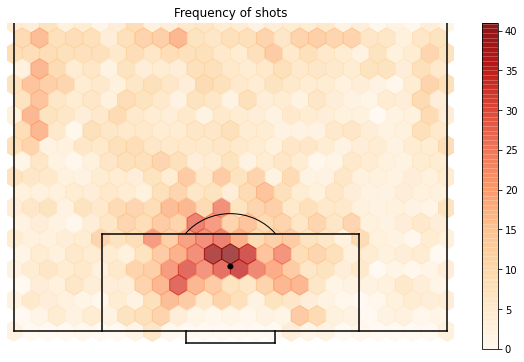

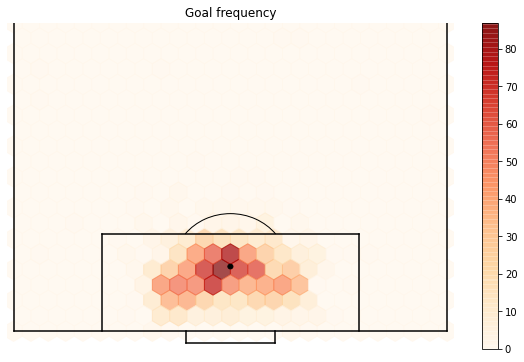

In [24]:
(fig,ax) = createGoalMouth()
pos=ax.hexbin(data =shots_only, x='y', y='x',zorder=1,cmap='OrRd',gridsize=(25,10),alpha=.7,extent=(0,68,0,52.5))
ax.set_xlim(-1, 69)
ax.set_ylim(-3,52.5)
plt.colorbar(pos, ax=ax)
ax.set_title('Frequency of shots')

fig, ax = createGoalMouth()
pos=ax.hexbin(data = goals_only,x='y', y='x',zorder=1,cmap='OrRd',gridsize=(25,10),alpha=.7,extent=(0,68,0,52.5))
ax.set_xlim(-1, 69)
ax.set_ylim(-3,52.5)
plt.colorbar(pos, ax=ax)
plt.axis('off')
ax.set_title('Goal frequency')

plt.show()

Plotting the first 750 shots and 250 goals if there's a tendency

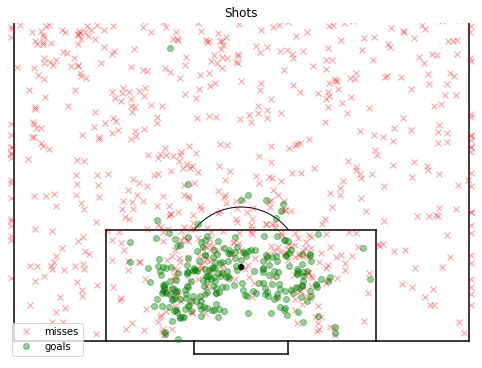

In [25]:
(fig,ax) = createGoalMouth((6.8,5.25))
shots_1000 = shots_only[0:750]
goals_1000 = goals_only[0:250]
ax.plot(shots_1000['y'], shots_1000['x'], 'rx', label='misses', alpha=0.4)
ax.plot(goals_1000['y'], goals_1000['x'], 'go', label='goals', alpha=0.4)
ax.set_title('Shots')
ax.legend()
plt.xlim((-1,69))
plt.ylim((-3,47.5))
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

## Building the model
We will use a model based on the logistic function, very useful for this kind of problema as we are interested in the probability of goals given some variables and the function outputs a value between 0 and 1.

In [14]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Showing first 200 shots results based on angle

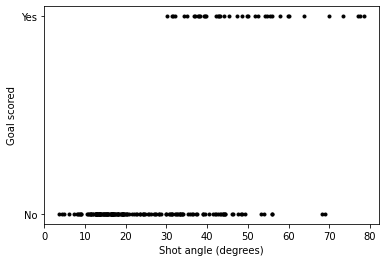

In [26]:
shots_200=shot_data.iloc[:200]

#Plot first 200 shots goal angle
fig,ax=plt.subplots(num=1)
ax.plot(shots_200['angle']*180/np.pi, shots_200['goal'], linestyle='none', marker= '.', color='black')
ax.set_ylabel('Goal scored')
ax.set_xlabel("Shot angle (degrees)")
plt.ylim((-0.05,1.05))
ax.set_yticks([0,1])
ax.set_yticklabels(['No','Yes'])
plt.show()

Show empirically how goal angle predicts probability of scoring


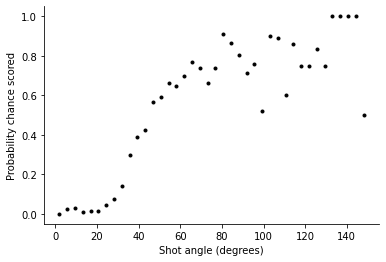

In [27]:
shotcount_dist=np.histogram(shot_data['angle']*180/np.pi,bins=40,range=[0, 150])
goalcount_dist=np.histogram(goals_only['angle']*180/np.pi,bins=40,range=[0, 150])
prob_goal=np.divide(goalcount_dist[0],shotcount_dist[0])
angle=shotcount_dist[1]
midangle= (angle[:-1] + angle[1:])/2
fig,ax=plt.subplots(num=2)
ax.plot(midangle, prob_goal, linestyle='none', marker= '.', color='black')
ax.set_ylabel('Probability chance scored')
ax.set_xlabel("Shot angle (degrees)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

### Model experiments
Build many models and evaluate their goodness of fit using the McFadden’s pseudo-R squared for Logistic Regression

#### Distance

In [51]:
model_variables = ['distance']
model=''
for v in model_variables[:-1]:
    model = model  + v + ' + '
model = model + model_variables[-1]

#Fit the model
test_model_1 = smf.glm(formula="goal ~ " + model, data=shot_data, family=sm.families.Binomial()).fit()
print(test_model_1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   goal   No. Observations:                 5989
Model:                            GLM   Df Residuals:                     5987
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2015.8
Date:                Thu, 21 Apr 2022   Deviance:                       4031.6
Time:                        18:37:05   Pearson chi2:                 5.06e+04
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.3967      0.122     27.794      0.0

In [56]:
#Mcfaddens Rsquared for Logistic regression
null_model = smf.glm(formula="goal ~ 1 ", data=shot_data, family=sm.families.Binomial()).fit()
1-test_model_1.llf/null_model.llf

0.43839002317300446

#### Distance and Distance²

In [53]:
model_variables = ['distance', 'distance_sqrd']
model=''
for v in model_variables[:-1]:
    model = model  + v + ' + '
model = model + model_variables[-1]

#Fit the model
test_model_2 = smf.glm(formula="goal ~ " + model, data=shot_data, family=sm.families.Binomial()).fit()
print(test_model_2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   goal   No. Observations:                 5989
Model:                            GLM   Df Residuals:                     5986
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2011.9
Date:                Thu, 21 Apr 2022   Deviance:                       4023.9
Time:                        18:37:18   Pearson chi2:                 1.07e+04
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         3.9743      0.233     17.031

In [57]:
#Mcfaddens Rsquared for Logistic regression
null_model = smf.glm(formula="goal ~ 1 ", data=shot_data, family=sm.families.Binomial()).fit()
1-test_model_2.llf/null_model.llf

0.4394652258314098

#### Position

In [55]:
model_variables = ['x', 'y']
model=''
for v in model_variables[:-1]:
    model = model  + v + ' + '
model = model + model_variables[-1]

#Fit the model
test_model_3 = smf.glm(formula="goal ~ " + model, data=shot_data, family=sm.families.Binomial()).fit()
print(test_model_3.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   goal   No. Observations:                 5989
Model:                            GLM   Df Residuals:                     5986
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2487.0
Date:                Thu, 21 Apr 2022   Deviance:                       4974.0
Time:                        18:37:31   Pearson chi2:                 6.48e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.4015      0.118     11.850      0.0

In [58]:
#Mcfaddens Rsquared for Logistic regression
null_model = smf.glm(formula="goal ~ 1 ", data=shot_data, family=sm.families.Binomial()).fit()
1-test_model_3.llf/null_model.llf

0.3071114399203544

#### Position x and distance from center

In [59]:
model_variables = ['x', 'dist_c']
model=''
for v in model_variables[:-1]:
    model = model  + v + ' + '
model = model + model_variables[-1]

#Fit the model
test_model_4 = smf.glm(formula="goal ~ " + model, data=shot_data, family=sm.families.Binomial()).fit()
print(test_model_4.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   goal   No. Observations:                 5989
Model:                            GLM   Df Residuals:                     5986
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2070.8
Date:                Thu, 21 Apr 2022   Deviance:                       4141.6
Time:                        18:41:08   Pearson chi2:                 4.94e+04
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.1288      0.113     27.598      0.0

In [60]:
#Mcfaddens Rsquared for Logistic regression
null_model = smf.glm(formula="goal ~ 1 ", data=shot_data, family=sm.families.Binomial()).fit()
1-test_model_4.llf/null_model.llf

0.42306443269258165

#### Angle

In [61]:
model_variables = ['angle']
model=''
for v in model_variables[:-1]:
    model = model  + v + ' + '
model = model + model_variables[-1]

#Fit the model
test_model_5 = smf.glm(formula="goal ~ " + model, data=shot_data, family=sm.families.Binomial()).fit()
print(test_model_5.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   goal   No. Observations:                 5989
Model:                            GLM   Df Residuals:                     5987
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2280.6
Date:                Thu, 21 Apr 2022   Deviance:                       4561.2
Time:                        18:41:47   Pearson chi2:                 1.00e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.2053      0.100    -42.041      0.0

In [62]:
#Mcfaddens Rsquared for Logistic regression
null_model = smf.glm(formula="goal ~ 1 ", data=shot_data, family=sm.families.Binomial()).fit()
1-test_model_5.llf/null_model.llf

0.3646056369323919

#### Angle, players nearby

In [64]:
model_variables = ['angle', 'players_in_between']
model=''
for v in model_variables[:-1]:
    model = model  + v + ' + '
model = model + model_variables[-1]

#Fit the model
test_model_6 = smf.glm(formula="goal ~ " + model, data=shot_data, family=sm.families.Binomial()).fit()
print(test_model_6.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   goal   No. Observations:                 5989
Model:                            GLM   Df Residuals:                     5986
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2032.5
Date:                Thu, 21 Apr 2022   Deviance:                       4065.0
Time:                        18:42:15   Pearson chi2:                 1.67e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -2.1754      0

In [65]:
#Mcfaddens Rsquared for Logistic regression
null_model = smf.glm(formula="goal ~ 1 ", data=shot_data, family=sm.families.Binomial()).fit()
1-test_model_6.llf/null_model.llf

0.43373511712200963

#### Combined positions and distances

In [66]:
model_variables = ['x', 'y', 'dist_c', 'distance', 'distance_sqrd']
model=''
for v in model_variables[:-1]:
    model = model  + v + ' + '
model = model + model_variables[-1]

#Fit the model
test_model_7 = smf.glm(formula="goal ~ " + model, data=shot_data, family=sm.families.Binomial()).fit()
print(test_model_7.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   goal   No. Observations:                 5989
Model:                            GLM   Df Residuals:                     5983
Model Family:                Binomial   Df Model:                            5
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1982.8
Date:                Thu, 21 Apr 2022   Deviance:                       3965.7
Time:                        18:42:41   Pearson chi2:                 1.03e+04
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         3.8107      0.282     13.526

In [67]:
#Mcfaddens Rsquared for Logistic regression
null_model = smf.glm(formula="goal ~ 1 ", data=shot_data, family=sm.families.Binomial()).fit()
1-test_model_7.llf/null_model.llf

0.44756648835817936

#### Distance, positions, angle and players nearby

In [68]:
model_variables = ['x', 'dist_c', 'distance', 'angle', 'players_in_between']
model=''
for v in model_variables[:-1]:
    model = model  + v + ' + '
model = model + model_variables[-1]

#Fit the model
test_model_8 = smf.glm(formula="goal ~ " + model, data=shot_data, family=sm.families.Binomial()).fit()
print(test_model_8.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   goal   No. Observations:                 5989
Model:                            GLM   Df Residuals:                     5983
Model Family:                Binomial   Df Model:                            5
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1801.2
Date:                Thu, 21 Apr 2022   Deviance:                       3602.4
Time:                        18:43:21   Pearson chi2:                 4.13e+04
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              5.4731      0

In [69]:
#Mcfaddens Rsquared for Logistic regression
null_model = smf.glm(formula="goal ~ 1 ", data=shot_data, family=sm.families.Binomial()).fit()
1-test_model_8.llf/null_model.llf

0.49818026806739457

#### Distance, positions, and players nearby

In [72]:
model_variables = ['x', 'dist_c', 'distance', 'players_in_between']
model=''
for v in model_variables[:-1]:
    model = model  + v + ' + '
model = model + model_variables[-1]

#Fit the model
test_model_9 = smf.glm(formula="goal ~ " + model, data=shot_data, family=sm.families.Binomial()).fit()
print(test_model_9.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   goal   No. Observations:                 5989
Model:                            GLM   Df Residuals:                     5984
Model Family:                Binomial   Df Model:                            4
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1801.2
Date:                Thu, 21 Apr 2022   Deviance:                       3602.4
Time:                        18:45:23   Pearson chi2:                 4.48e+04
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              5.5979      0

In [73]:
#Mcfaddens Rsquared for Logistic regression
null_model = smf.glm(formula="goal ~ 1 ", data=shot_data, family=sm.families.Binomial()).fit()
1-test_model_9.llf/null_model.llf

0.49817063864597366

#### Distance, position, angle and players nearby

In [75]:
model_variables = ['distance', 'angle', 'players_in_between']
model=''
for v in model_variables[:-1]:
    model = model  + v + ' + '
model = model + model_variables[-1]

#Fit the model
test_model_10 = smf.glm(formula="goal ~ " + model, data=shot_data, family=sm.families.Binomial()).fit()
print(test_model_10.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   goal   No. Observations:                 5989
Model:                            GLM   Df Residuals:                     5985
Model Family:                Binomial   Df Model:                            3
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1840.0
Date:                Thu, 21 Apr 2022   Deviance:                       3680.1
Time:                        18:46:23   Pearson chi2:                 1.41e+04
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              2.6786      0

In [76]:
#Mcfaddens Rsquared for Logistic regression
null_model = smf.glm(formula="goal ~ 1 ", data=shot_data, family=sm.families.Binomial()).fit()
1-test_model_10.llf/null_model.llf

0.4873548492904851

#### Distance, angle, distance from center and players nearby

In [83]:
model_variables = ['dist_c', 'distance', 'angle', 'players_in_between']
model=''
for v in model_variables[:-1]:
    model = model  + v + ' + '
model = model + model_variables[-1]

#Fit the model
test_model_11 = smf.glm(formula="goal ~ " + model, data=shot_data, family=sm.families.Binomial()).fit()
print(test_model_11.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   goal   No. Observations:                 5989
Model:                            GLM   Df Residuals:                     5984
Model Family:                Binomial   Df Model:                            4
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1837.2
Date:                Thu, 21 Apr 2022   Deviance:                       3674.4
Time:                        18:51:26   Pearson chi2:                 1.74e+04
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              3.1530      0

In [84]:
#Mcfaddens Rsquared for Logistic regression
null_model = smf.glm(formula="goal ~ 1 ", data=shot_data, family=sm.families.Binomial()).fit()
1-test_model_11.llf/null_model.llf

0.4881449018513748

#### Distance, angle, x position and players nearby

In [95]:
model_variables = ['distance', 'angle', 'players_in_between', 'x']
model=''
for v in model_variables[:-1]:
    model = model  + v + ' + '
model = model + model_variables[-1]

#Fit the model
test_model_12 = smf.glm(formula="goal ~ " + model, data=shot_data, family=sm.families.Binomial()).fit()
print(test_model_12.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   goal   No. Observations:                 5989
Model:                            GLM   Df Residuals:                     5984
Model Family:                Binomial   Df Model:                            4
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1821.4
Date:                Thu, 21 Apr 2022   Deviance:                       3642.8
Time:                        18:53:35   Pearson chi2:                 3.42e+04
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              4.5347      0

In [96]:
#Mcfaddens Rsquared for Logistic regression
null_model = smf.glm(formula="goal ~ 1 ", data=shot_data, family=sm.families.Binomial()).fit()
1-test_model_12.llf/null_model.llf

0.49254164581590243

### Chosen model

After analyzing the dataset and building many models, we decided to use the model based on the variables x position, angle, distance, and players between the shooter and the goal because those variables were among the best when it comes to fitting the data and the 4 were statistically significant.

In [97]:
model = test_model_12
print(model.summary())
model_params=model.params

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   goal   No. Observations:                 5989
Model:                            GLM   Df Residuals:                     5984
Model Family:                Binomial   Df Model:                            4
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1821.4
Date:                Thu, 21 Apr 2022   Deviance:                       3642.8
Time:                        18:55:06   Pearson chi2:                 3.42e+04
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              4.5347      0

In [98]:
model_params

Intercept             4.534684
distance             -0.310514
angle                 0.591834
players_in_between   -0.675362
x                     0.110713
dtype: float64

Useful function to return xG from model

In [106]:
def calculate_xG(sh): 
   bsum=-model_params[0]
   for i,v in enumerate(model_variables):
       bsum=bsum-model_params[i+1]*sh[v]
   xG = 1/(1+np.exp(bsum))
   return xG   

In [107]:
#Add an xG to the dataframe
xG=shot_data.apply(calculate_xG, axis=1)
shot_data = shot_data.assign(xG=xG)
shot_data

,x,y,distance,angle,players_in_between,goal,distance_sqrd,dist_c,xG
0,52.1661,29.6488,52.347253,0.265364,5,0,2740.234931,4.3512,0.000105
1,20.1485,21.3749,23.777199,0.500704,3,0,565.355202,12.6251,0.087263
2,14.3825,24.8187,17.063194,0.694654,2,1,291.152576,9.1813,0.472290
3,42.2679,4.5545,51.513230,0.223721,4,0,2653.612841,29.4455,0.000087
4,41.3071,5.7849,50.023678,0.231823,3,0,2502.368378,28.2151,0.000245
...,...,...,...,...,...,...,...,...,...
5984,35.3460,11.5714,41.861460,0.283130,2,0,1752.381814,22.4286,0.003224
5985,18.6453,24.9418,20.729163,0.601883,9,0,429.698199,9.0582,0.003835
5986,45.6519,3.0709,55.142590,0.210771,2,0,3040.705200,30.9291,0.000157
5987,50.2435,29.7878,50.419757,0.275377,2,0,2542.151921,4.2122,0.001174


Final results: showing xG from position on the pitch!

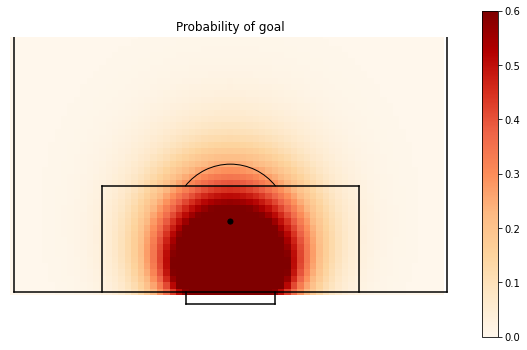

In [108]:
#Create a 2D map of xG
pgoal_2d=np.zeros((52,68))
for x in range(52):
    for y in range(68):
        sh=dict()
        a = np.arctan(14.02 *x /(x**2 + abs(y-68/2)**2 - (7.01)**2))
        if a<0:
            a = np.pi + a
        sh['angle'] = a
        sh['distance'] = np.sqrt(x**2 + abs(y-68/2)**2)
        sh['x']=x
        sh['players_in_between'] = 3
        
        pgoal_2d[x,y] = calculate_xG(sh)

(fig,ax) = createGoalMouth()
pos=ax.imshow(pgoal_2d, aspect='auto',cmap=plt.cm.OrRd, vmin=0, vmax=0.6)
fig.colorbar(pos, ax=ax)
ax.set_title('Probability of goal')
plt.xlim((-1,69))
plt.ylim((-3,40))
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

Additionally, we show also the xG contours

In [109]:
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

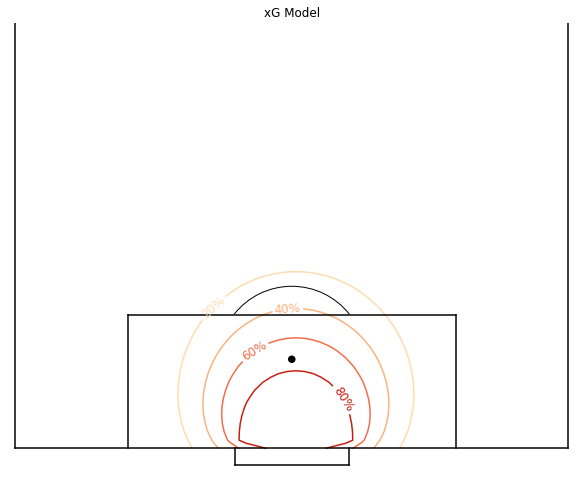

In [110]:
x1 = np.linspace(0, 52 , 52)
x_0 = np.linspace(0, 68, 68)

fig, ax = createGoalMouth((10.2,8.28))

CS = ax.contour(x_0,x1, pgoal_2d, alpha=1, cmap='OrRd',levels=5)

# Define a class that forces representation of float to look a certain way
# This remove trailing zero so '1.0' becomes '1'
class nf(float):
    def __repr__(self):
        str = '%.1f' % (self.__float__(),)
        if str[-1] == '0':
            return '%.0f' % self.__float__()
        else:
            return '%.1f' % self.__float__()


# Recast levels to new class
CS.levels = [nf(val*100) for val in CS.levels]

# Label levels with specially formatted floats
if plt.rcParams["text.usetex"]:
    fmt = r'%r\%%'
else:
    fmt = '%r%%'
ax.clabel(CS, CS.levels[0::1],inline=True, fmt=fmt, fontsize=12)

ax.set_title('xG Model')

ax.set_xlim(-1,69)
ax.set_ylim(-3,52.5)
plt.show()

## Evaluating the model's predictive power


### Log likelihood
The likelihood function (often simply called the likelihood) describes the joint probability of the observed data as a function of the parameters of the chosen statistical model. In general, the closer to 1 the value is, the greater the predictive power of the model.

In [111]:
#Mcfaddens Rsquared for Logistic regression
null_model = smf.glm(formula="goal ~ 1 ", data=shot_data, family=sm.families.Binomial()).fit()
1-model.llf/null_model.llf

0.49254164581590243

### ROC Curve
A receiver operating characteristic curve, or ROC curve, is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied.

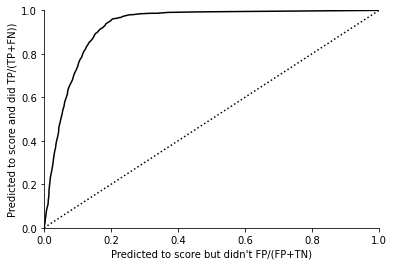

In [112]:
#ROC curve
numobs=100
TP=np.zeros(numobs)
FP=np.zeros(numobs)
TN=np.zeros(numobs)
FN=np.zeros(numobs)


for i,threshold in enumerate(np.arange(0,1,1/numobs)):
    for j,shot in shot_data.iterrows():
        if (shot['goal']==1): 
            if(shot['xG']>threshold):
                TP[i] = TP[i] + 1
            else:
                FN[i] = FN[i] + 1
        if (shot['goal']==0): 
            if(shot['xG']>threshold):
                FP[i] = FP[i] + 1
            else:
                TN[i] = TN[i] + 1
     

fig,ax=plt.subplots(num=1)
ax.plot(FP/(FP+TN), TP/(TP+FN), color='black')
ax.plot([0,1], [0,1], linestyle='dotted', color='black')
ax.set_ylabel("Predicted to score and did TP/(TP+FN))")
ax.set_xlabel("Predicted to score but didn't FP/(FP+TN)")
plt.ylim((0.00,1.00))
plt.xlim((0.00,1.00))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

## Sources:
* [Friends of Tracking 1](https://www.youtube.com/watch?v=bpjLyFyLlXs)
* [Friends of Tracking 2](https://www.youtube.com/watch?v=wHOgINJ5g54)
* [Friends of Tracking 3](https://www.youtube.com/watch?v=310_eW0hUqQ)
* [Tifo Football](https://www.youtube.com/watch?v=zSaeaFcm1SY)
* [Bundesliga YT channel](https://www.youtube.com/watch?v=_vGhocyvKhA)
* [Football Made Simple](https://youtu.be/CCGtjXR4GAk)
* [The Geometry of Shooting | by David Sumpter | Medium](https://soccermatics.medium.com/the-geometry-of-shooting-ae7a67fdf760)
* [Friends-of-Tracking-Data-FoTD/SoccermaticsForPython: This repo is dedicated for people getting started with Python using the concepts derived from the book Soccermatics (Sumpter 2016)](https://github.com/Friends-of-Tracking-Data-FoTD/SoccermaticsForPython)
* [eddwebster/xG_Model_Workflow: Comprehensive Guide to explaining, creating and using an xG model](https://github.com/eddwebster/xG_Model_Workflow)